In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib.colors import Normalize
import pandas as pd
import numpy as np
from variability_utils import *

codex_meta = pd.read_csv('data/column_assignment.csv')
codex_meta["root_id"] = pd.to_numeric(codex_meta["root_id"], errors="coerce") 
root_ids = codex_meta["root_id"].dropna().astype("int64").to_numpy()
fafb_meta = pd.read_feather('data/fafb_783_meta.feather')
fafb_meta["fafb_783_id"] = pd.to_numeric(fafb_meta["fafb_783_id"], errors="coerce") 
fafb_meta["fafb_783_id"] = fafb_meta["fafb_783_id"].dropna().astype("int64")

edge_df = pd.read_csv('data/connections_princeton.csv')


In [2]:
# def plot_eye(ax, nodes_coords, edges_annot, ctype1, ctype2, norm, cmap, *,
#              mirror_x=False, mirror_y=True, x_offset=0.0, y_offset=0.0, hexsize=1.0, plot_col_ids=False):
#     type_pair = edges_annot[(edges_annot["pre_cell_type"]==ctype1) &
#                             (edges_annot["post_cell_type"]==ctype2)].copy()

#     # per-column syn count (enforce 0/1 edge per column; change later if needed)
#     syn_by_col = type_pair.groupby("column_id")["syn_count"].agg(list).to_dict()

#     def nsyns_for_col(cid):
#         vals = syn_by_col.get(cid, [])
#         if len(vals) == 0:
#             return 0
#         if len(vals) == 1:
#             return int(vals[0])
#         raise ValueError(f"Column {cid} has {len(vals)} edges; choose aggregation.")

#     colpos = nodes_coords[["column_id", "p", "q"]].drop_duplicates("column_id").copy()
#     x, y = pq_to_xy(colpos["p"].to_numpy(), colpos["q"].to_numpy(), hexsize=hexsize)

#     # optional mirrors / offsets to place eyes into same canvas
#     if mirror_x:
#         x = -x
#     if mirror_y:
#         y = -y
#     x = x + x_offset
#     y = y + y_offset

#     for xi, yi, cid in zip(x, y, colpos["column_id"].to_numpy()):
#         nsyns = nsyns_for_col(cid)
#         color = cmap(norm(nsyns))
#         ax.add_patch(
#             RegularPolygon(
#                 (xi, yi), numVertices=6, radius=hexsize, orientation=np.pi/6,
#                 facecolor=color, edgecolor="black", linewidth=0.4
#             )
#         )
#         if plot_col_ids:
#             ax.text(xi, yi, str(cid), fontsize=6, ha="center", va="center", color="white")

#     return x, y


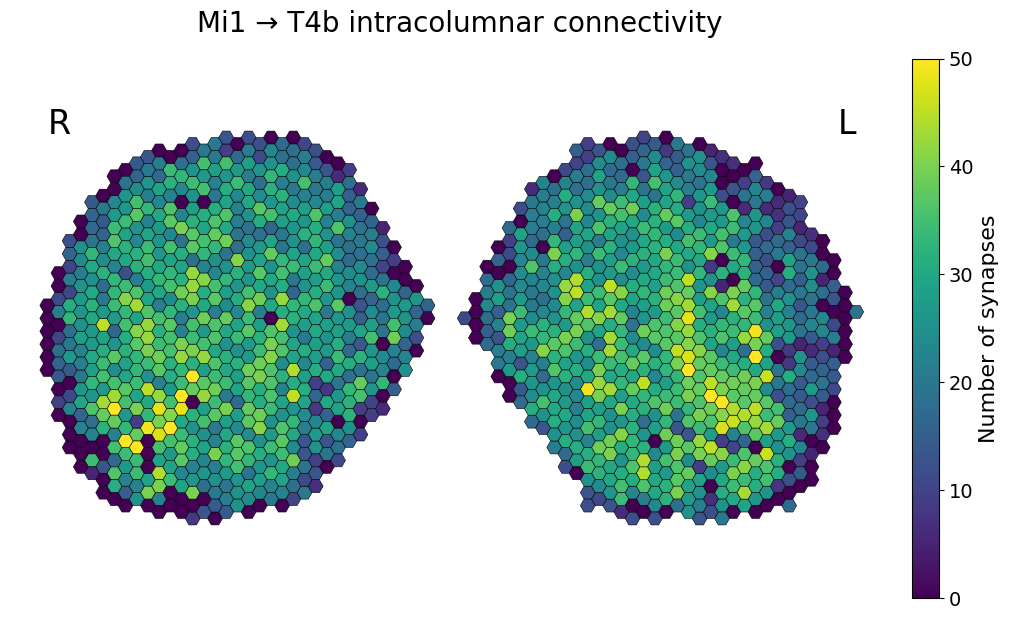

In [ ]:
ctype1, ctype2 = "Mi1", "T4b"
cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=50)

nodes_R = build_nodes_coords_for_side("right",fafb_meta, codex_meta, root_ids)
edges_R = build_edges_for_nodes(nodes_R, edge_df)

nodes_L = build_nodes_coords_for_side("left",fafb_meta, codex_meta, root_ids)
edges_L = build_edges_for_nodes(nodes_L, edge_df)

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_aspect("equal")
ax.axis("off")
fig.suptitle(f"{ctype1} → {ctype2} intracolumnar connectivity", fontsize=20, y=0.95)

# compute a spacing so the eyes don't overlap
# (use right eye extent as a scale)
colpos_R = nodes_R[["column_id","p","q"]].drop_duplicates("column_id")
xR0, yR0 = pq_to_xy(colpos_R["p"].to_numpy(), colpos_R["q"].to_numpy(), hexsize=1.0)
eye_width = xR0.max() - xR0.min()
gap = 4.0  # tweak

# Place right eye centered left, left eye centered right
xR, yR = plot_eye(ax, nodes_R, edges_R, ctype1, ctype2, norm, cmap,
                  mirror_x=True, x_offset=-(eye_width/2 + gap), hexsize=1.0, plot_col_ids=False)
xL, yL = plot_eye(ax, nodes_L, edges_L, ctype1, ctype2, norm, cmap,
                  mirror_x=False,  x_offset=+(eye_width/2 + gap), hexsize=1.0, plot_col_ids=False)

# bounds
xmin = min(xR.min(), xL.min()) - 5
xmax = max(xR.max(), xL.max()) + 5
ymin = min(yR.min(), yL.min()) - 5
ymax = max(yR.max(), yL.max()) + 5
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# labels + colorbar
ax.text(xR.min(), ymax-1, "R", fontsize=24, ha="left", va="top")
ax.text(xL.max(), ymax-1, "L",  fontsize=24, ha="right", va="top")

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(mappable, ax=ax, fraction=0.03, pad=0.02)
cb.set_label("Number of synapses", fontsize=16)
cb.ax.tick_params(labelsize=14)
plt.show()
